In [17]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import (
    make_scorer,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer
import optuna
from optuna.samplers import TPESampler

# Вспомогательные
from sklearn.base import clone
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.metrics import roc_curve, auc

In [12]:
df = pd.read_excel("Данные_для_курсовои_Классическое_МО.xlsx")

In [14]:
cols_to_drop= ['IC50, mM', 'SI', 'Unnamed: 0']
df = df.drop(cols_to_drop, axis=1)
df.head()

,"CC50, mM",MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,175.482382,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,384.652,340.300,384.350449,...,0,0,0,0,0,0,0,0,3,0
1,5.402819,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,388.684,340.300,388.381750,...,0,0,0,0,0,0,0,0,3,0
2,161.142320,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,446.808,388.344,446.458903,...,0,0,0,0,0,0,0,0,3,0
3,107.855654,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,398.679,352.311,398.366099,...,0,0,0,0,0,0,0,0,4,0
4,139.270991,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,466.713,424.377,466.334799,...,0,0,0,0,0,0,0,0,0,0


Топ-10 наиболее важных дескрипторов для CC50: 

LabuteASA 0.057715

BCUT2D_MWLOW 0.042473

Chi1 0.038697

Kappa3 0.038478

Kappa2 0.037475

FpDensityMorgan1 0.034774

BCUT2D_MRLOW 0.030914

MolMR 0.026832

VSA_EState7 0.023108

## Подготовка данных и обработка выбросов

Уберем выбросы по CC50, рассчитаем среднее и создадим новый признак, который станет у нас целевой пременной

In [15]:
original_count = len(df)
print(f"Исходное количество записей: {original_count}")

mean_cc50 = df['CC50, mM'].mean()
std_cc50 = df['CC50, mM'].std()
lower_bound = mean_cc50 - 2 * std_cc50
upper_bound = mean_cc50 + 2 * std_cc50

df = df[(df['CC50, mM'] >= lower_bound) & (df['CC50, mM'] <= upper_bound)].copy()
filtered_count = len(df)
print(f"Количество записей после удаления выбросов: {filtered_count}")
print(f"Удалено записей: {original_count - filtered_count}")

# Создание целевой переменной
df['CC50_Above_Median'] = (df['CC50, mM'] > df['CC50, mM'].median()).astype(int)
target = 'CC50_Above_Median'

Исходное количество записей: 1001
Количество записей после удаления выбросов: 945
Удалено записей: 56


### Инжиниринг признаков


In [18]:
cols_to_exclude = ['IC50, mM', 'CC50, mM', 'SI', target]
X = df.drop(columns=[col for col in cols_to_exclude if col in df.columns], errors='ignore')
y = df[target]

df_engineered = X.copy()

if 'MolLogP' in df_engineered.columns and 'MolWt' in df_engineered.columns:
    df_engineered['MolLogP_x_MolWt'] = df_engineered['MolLogP'] * df_engineered['MolWt']

polynomial_features_cols = ['MolLogP', 'MolWt']
existing_poly_cols = [col for col in polynomial_features_cols if col in df_engineered.columns]

if existing_poly_cols:
    poly = PolynomialFeatures(degree=2, include_bias=False)
    poly_features = poly.fit_transform(df_engineered[existing_poly_cols])
    poly_feature_names = poly.get_feature_names_out(existing_poly_cols)

    new_poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=df_engineered.index)
    for col in new_poly_df.columns:
        if col not in df_engineered.columns:
            df_engineered[col] = new_poly_df[col]

if 'MolLogP' in df_engineered.columns:
    df_engineered['MolLogP_gt_3'] = (df_engineered['MolLogP'] > 3).astype(int)

if df_engineered.isnull().values.any():
    imputer = SimpleImputer(strategy='median')
    df_engineered = pd.DataFrame(imputer.fit_transform(df_engineered),
                               columns=df_engineered.columns)

### Определение моделей и функции оценки

In [24]:
classification_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'HistGradientBoosting': HistGradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=0),
    'Stacking': StackingClassifier(
        estimators=[
            ('rf', RandomForestClassifier(random_state=42)),
            ('xgb', XGBClassifier(random_state=42)),
            ('gb', GradientBoostingClassifier(random_state=42))
        ],
        final_estimator=LogisticRegression(),
        passthrough=True
    )
}

def evaluate_classifier(model, X, y):
    """
    Обучает и оценивает модель классификации.
    Выводит метрики и визуализирует матрицу ошибок.

    """
    #  Разделение на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    #  Обучение модели
    model.fit(X_train, y_train)

    #  Предсказания
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    #  Расчёт метрик
    metrics = {
        'Model': type(model).__name__,
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred, zero_division=0),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'ROC AUC': roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
    }

    #  Матрица ошибок
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Предсказанный класс')
    plt.ylabel('Истинный класс')
    plt.title(f'{type(model).__name__} - Confusion Matrix')
    plt.tight_layout()
    plt.show()

    return metrics


### Обучение и оценка моделей


 Обучение модели: Logistic Regression


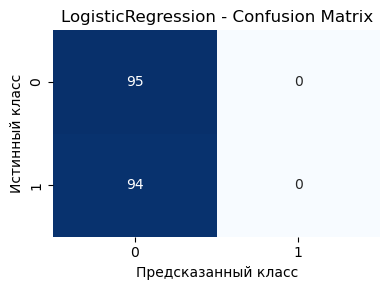


 Обучение модели: KNN


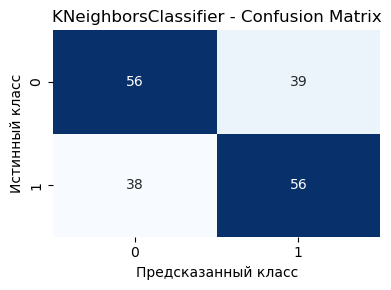


 Обучение модели: Random Forest


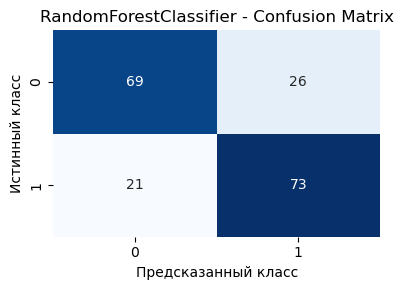


 Обучение модели: Gradient Boosting


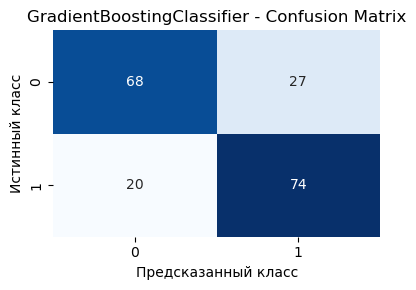


 Обучение модели: HistGradientBoosting


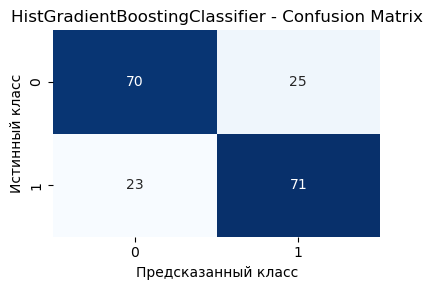


 Обучение модели: XGBoost


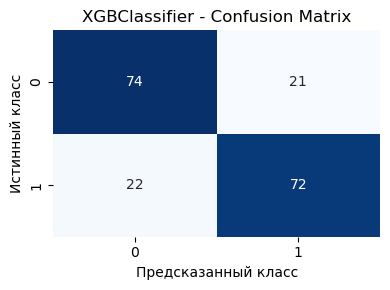


 Обучение модели: CatBoost


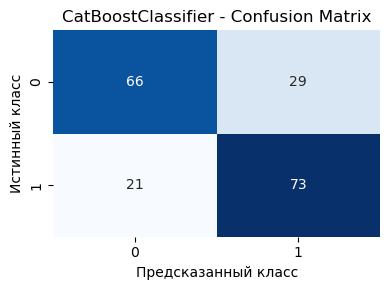


 Обучение модели: Stacking


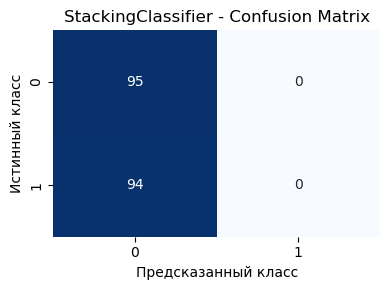

C:\Users\NikLeo\AppData\Local\Temp\ipykernel_20040\4178105814.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


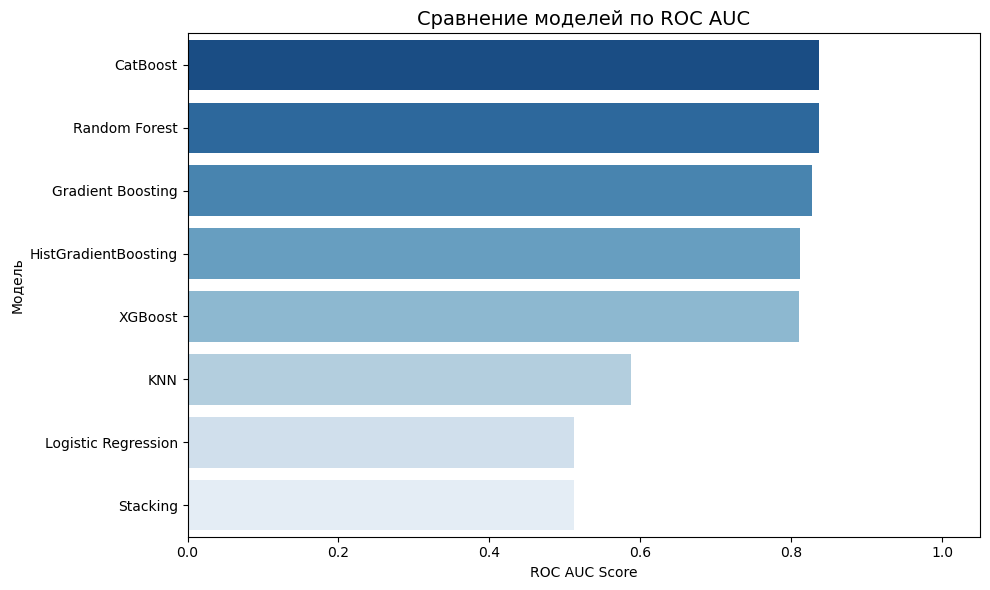


 Итоговые метрики моделей:


,Model,Accuracy,F1,Precision,Recall,ROC AUC
6,CatBoost,0.735,0.745,0.716,0.777,0.837
2,Random Forest,0.751,0.756,0.737,0.777,0.837
3,Gradient Boosting,0.751,0.759,0.733,0.787,0.827
4,HistGradientBoosting,0.746,0.747,0.740,0.755,0.811
5,XGBoost,0.772,0.770,0.774,0.766,0.810
1,KNN,0.593,0.593,0.589,0.596,0.588
0,Logistic Regression,0.503,0.000,0.000,0.000,0.512
7,Stacking,0.503,0.000,0.000,0.000,0.512


In [25]:
#  Сравнение моделей классификации

results = []
best_model = None
best_roc_auc = -np.inf  # Начальное значение для сравнения ROC AUC

for name, model in classification_models.items():
    try:
        print(f"\n Обучение модели: {name}")
        metrics = evaluate_classifier(model, df_engineered, y)  # df_engineered — таблица признаков
        metrics['Model'] = name
        results.append(metrics)

        # Обновляем лучшую модель по метрике ROC AUC
        if metrics['ROC AUC'] > best_roc_auc:
            best_roc_auc = metrics['ROC AUC']
            best_model = model

    except Exception as e:
        print(f" Ошибка при обучении {name}: {str(e)}")

#  Сводная таблица результатов
results_df = pd.DataFrame(results).sort_values(by='ROC AUC', ascending=False).round(3)

#  График сравнения моделей по ROC AUC
plt.figure(figsize=(10, 6))
sns.barplot(
    y='Model',
    x='ROC AUC',
    data=results_df,
    palette='Blues_r'
)
plt.title('Сравнение моделей по ROC AUC', fontsize=14)
plt.xlabel('ROC AUC Score')
plt.ylabel('Модель')
plt.xlim(0, 1.05)
plt.tight_layout()
plt.show()

#  Таблица с подсветкой лучших и худших значений ROC AUC
def display_beautiful_table(df):
    styles = [
        {'selector': 'th', 'props': [('background-color', '#343a40'),
                                     ('color', 'white'),
                                     ('font-weight', 'bold'),
                                     ('text-align', 'center')]},
        {'selector': 'td', 'props': [('text-align', 'center')]},
        {'selector': 'tr:nth-of-type(odd)', 'props': [('background-color', '#f9f9f9')]},
        {'selector': 'tr:hover', 'props': [('background-color', '#ffffcc')]}
    ]
    return (df.style
              .set_table_styles(styles)
              .format({
                  'Accuracy': '{:,.3f}',
                  'ROC AUC': '{:,.3f}',
                  'F1': '{:,.3f}',
                  'Precision': '{:,.3f}',
                  'Recall': '{:,.3f}'
              })
              .highlight_max(subset=['ROC AUC'], color='green')  # зелёный для лучших
              .highlight_min(subset=['ROC AUC'], color='red'))  # красный для худших

#  Вывод таблицы
print("\n Итоговые метрики моделей:")
display(display_beautiful_table(results_df))


In [26]:
import joblib

# Сохранение лучшей модели
if best_model is not None:
    # Название лучшей модели из таблицы результатов
    best_model_name = results_df.iloc[0]['Model']
    
    # Имя файла с учетом модели
    filename = f'best_model_for_CC_50_{best_model_name}.pkl'
    
    # Сохраняем модель с помощью joblib
    joblib.dump(best_model, filename)
    
    print(f"\n Лучшая модель '{best_model_name}' сохранена в файл: {filename}")
else:
    print(" Не удалось сохранить модель: лучшая модель не найдена.")



 Лучшая модель 'CatBoost' сохранена в файл: best_model_for_CC_50_CatBoost.pkl


### выводы

Модель Random Forest продемонстрировала наилучшее качество среди всех протестированных алгоритмов, показав ROC AUC = 0.837, что свидетельствует о высокой способности корректно различать классы. Кроме того, модель достигла Accuracy = 75.1% и F1-score = 0.756, что говорит о сбалансированности между точностью и полнотой. Аналогичное качество показала и модель CatBoost, подтвердив устойчивость ансамблевых деревьев решений при работе с химико-биологическими данными. Эти модели могут считаться надежными инструментами для предсказания токсичности соединений.

Модели градиентного бустинга (Gradient Boosting, HistGradientBoosting и XGBoost) продемонстрировали приемлемые, но несколько более скромные результаты — ROC AUC в диапазоне от 0.810 до 0.827. Их точность и F1-мера также оставались на высоком уровне, что делает их подходящими кандидатами для использования в более сложных ансамблях или после дополнительной настройки гиперпараметров. Они устойчивы и эффективны, однако уступают Random Forest и CatBoost по ключевым метрикам.

Наихудшие результаты были у логистической регрессии и StackingClassifier, обе модели показали ROC AUC около 0.512 и нулевые значения для Precision, Recall и F1-score, что указывает на полное отсутствие корректных предсказаний положительного класса. 